# Τεχνικές Εξόρυξης Δεδομένων
# Μέλη: 
## 1. Αποστολοπούλου Αλεξάνδρα (1115201700005)
## 2. Μπριάκος Σπυρίδων (1115201700101)
## Εργασία 2η

# 4. Υλοποίηση Συσταδοποίησης (Clustering)

In [0]:
import pandas as pd
import string
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import time

## a. Καθάρισμα δεδομένων
Αρχικά, φορτώνουμε τα δεδομμένα από το αρχείο train.tsv

In [0]:
from google.colab import drive,files
import pandas as pd
import io
uploaded = files.upload()

train_data = pd.read_csv(io.StringIO(uploaded['train_set.tsv'].decode('utf-8')),sep='\t')

valid_categories = train_data['category'].tolist()
train_data = train_data[['id','content']].copy()
display(train_data)

Saving train_set.tsv to train_set.tsv


,id,content
0,1627,Britain's Kelly Holmes marked her first appear...
1,39,"The head of Lloyd's of London, the insurance m..."
2,849,Singer George Michael has said that a new film...
3,1938,"Fake bank e-mails, or phishing, and stories ab..."
4,514,Rock 'n' roll legend Elvis is set to top the U...
...,...,...
1775,398,Our mission to brighten up your working lives ...
1776,958,Record numbers of schools across the UK are to...
1777,875,DJ duo JK and Joel are taking over BBC Radio 1...
1778,1428,Southampton's David Prutton faces a possible s...


#### Μετατροπή κεφαλαίων γραμμάτων σε πεζά και αφαίρεση σημείων στίξης.

In [0]:
import string
#Get rid of the punctuations and the symbols.
for i, row in train_data.iterrows():
    train_data.loc[i,'content']  =  train_data.loc[i,'content'].lower()
    train_data.loc[i,'content'] = ''.join(ch for ch in train_data['content'][i] if ch not in set(string.punctuation))
    
display(train_data)

,id,content
0,1627,britains kelly holmes marked her first appeara...
1,39,the head of lloyds of london the insurance mar...
2,849,singer george michael has said that a new film...
3,1938,fake bank emails or phishing and stories about...
4,514,rock n roll legend elvis is set to top the uk ...
...,...,...
1775,398,our mission to brighten up your working lives ...
1776,958,record numbers of schools across the uk are to...
1777,875,dj duo jk and joel are taking over bbc radio 1...
1778,1428,southamptons david prutton faces a possible se...


#### **Tokenization** and **Lemmanization**

In [0]:
import nltk
nltk.download('wordnet')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

train_data['content'] = train_data.content.apply(lemmatize_text).copy()
train_data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,content
0,1627,"[britain, kelly, holmes, marked, her, first, a..."
1,39,"[the, head, of, lloyd, of, london, the, insura..."
2,849,"[singer, george, michael, ha, said, that, a, n..."
3,1938,"[fake, bank, email, or, phishing, and, story, ..."
4,514,"[rock, n, roll, legend, elvis, is, set, to, to..."
...,...,...
1775,398,"[our, mission, to, brighten, up, your, working..."
1776,958,"[record, number, of, school, across, the, uk, ..."
1777,875,"[dj, duo, jk, and, joel, are, taking, over, bb..."
1778,1428,"[southamptons, david, prutton, face, a, possib..."


#### Stemming

In [0]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

train_data['content'] = train_data['content'].apply(lambda x: word_stemmer(x))
train_data

,id,content
0,1627,britain kelli holm mark her first appear on ho...
1,39,the head of lloyd of london the insur market h...
2,849,singer georg michael ha said that a new film a...
3,1938,fake bank email or phish and stori about id th...
4,514,rock n roll legend elvi is set to top the uk s...
...,...,...
1775,398,our mission to brighten up your work life cont...
1776,958,record number of school across the uk are to t...
1777,875,dj duo jk and joel are take over bbc radio 1 f...
1778,1428,southampton david prutton face a possibl seven...


## b. Vectorization

#### i. Bag-Of-Words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
bowX = count_vectorizer.fit_transform(train_data['content'])
print(bowX.shape)

(1780, 27072)


#### ii. Tf-Idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidfX = tfidf_vectorizer.fit_transform(train_data['content'])
print(tfidfX.shape)

(1780, 27072)


#### iii. Word2Vec

In [0]:
#Prepare train_data for Word2Vec, tokenization
from nltk import word_tokenize
import nltk 
nltk.download('punkt')
tokens = []
for i, row in train_data.iterrows():
    tokens.append(word_tokenize(train_data.loc[i,'content']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##### Download Google News Word2Vec Pre-Train Model (~1,5GB, with 3M Vectors)

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-05-03 10:54:23--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.47.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.47.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  80.1MB/s    in 21s     

2020-05-03 10:54:44 (75.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



##### Load Google's Pre-Trained Model

In [0]:
import gensim
from gensim.models import Word2Vec
from gensim import models

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
model = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE ,binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#####  Yπολογίζουμε για κάθε άρθρο το μέσο διάνυσμα
##### Ο πίνακας mean_vectors έχει διαστάσεις (1780,300)

In [0]:
import numpy as np

vectors_of_article = []
mean_vectors = []
for i in range(len(tokens)):
    for j in range(len(tokens[i])):
        if tokens[i][j] in model.vocab:
            vectors_of_article.append(list(model[tokens[i][j]]))
    mean_vectors.append(np.mean(vectors_of_article,axis=0))
    vectors_of_article = []

print(len(mean_vectors))
print(len(mean_vectors[5]))

1780
300


## c. Tεχνικές Συμπίεσης Διάστασης

### i. Principal Component Analysis

In [0]:
#DIMENSIONAL COMPRESSION TECHNIQUE PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_bowX = pca.fit_transform(bowX.toarray())
pca_tfidfX = pca.fit_transform(tfidfX.toarray())
pca_w2vX = pca.fit_transform(np.array(mean_vectors))
print(pca_bowX.shape)
print(pca_tfidfX.shape)
print(pca_w2vX.shape)

#Store dataframes so as to display real categories later with scatter plot. 
#BoW
x = [i[0] for i in pca_bowX]
y = [i[1] for i in pca_bowX]    
temp_list = list(zip(x,y,valid_categories))
pca_bowX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Tfidf
x = [i[0] for i in pca_tfidfX]
y = [i[1] for i in pca_tfidfX]    
temp_list = list(zip(x,y,valid_categories))
pca_tfidfX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Word2Vec
x = [i[0] for i in pca_w2vX]
y = [i[1] for i in pca_w2vX]    
temp_list = list(zip(x,y,valid_categories))
pca_w2vX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

(1780, 2)
(1780, 2)
(1780, 2)


### ii. Singular Value Decomposition

In [0]:
#DIMENSIONAL COMPRESSION TECHNIQUE SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
svd_bowX = svd.fit_transform(bowX.toarray())
svd_tfidfX = svd.fit_transform(tfidfX.toarray())
svd_w2vX = svd.fit_transform(np.array(mean_vectors))
print(svd_bowX.shape)
print(svd_tfidfX.shape)
print(svd_w2vX.shape)

#Store dataframes so as to display real categories later with scatter plot.
#BoW
x = [i[0] for i in svd_bowX]
y = [i[1] for i in svd_bowX]    
temp_list = list(zip(x,y,valid_categories))
svd_bowX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Tfidf
x = [i[0] for i in svd_tfidfX]
y = [i[1] for i in svd_tfidfX]    
temp_list = list(zip(x,y,valid_categories))
svd_tfidfX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Word2Vec
x = [i[0] for i in svd_w2vX]
y = [i[1] for i in svd_w2vX]    
temp_list = list(zip(x,y,valid_categories))
svd_w2vX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

(1780, 2)
(1780, 2)
(1780, 2)


### iii. Independent Component Analysis

In [0]:
#DIMENSIONAL COMPRESSION TECHNIQUE ICA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
ica_bowX = ica.fit_transform(bowX.toarray())
ica_tfidfX = ica.fit_transform(tfidfX.toarray())
ica_w2vX = ica.fit_transform(np.array(mean_vectors))
print(ica_bowX.shape)
print(ica_tfidfX.shape)
print(ica_w2vX.shape)

#Store dataframes so as to display real categories later with scatter plot.
#BoW
x = [i[0] for i in ica_bowX]
y = [i[1] for i in ica_bowX]    
temp_list = list(zip(x,y,valid_categories))
ica_bowX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Tfidf
x = [i[0] for i in ica_tfidfX]
y = [i[1] for i in ica_tfidfX]    
temp_list = list(zip(x,y,valid_categories))
ica_tfidfX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

#Word2Vec
x = [i[0] for i in ica_w2vX]
y = [i[1] for i in ica_w2vX]    
temp_list = list(zip(x,y,valid_categories))
ica_w2vX_df = pd.DataFrame(temp_list, columns = ['x', 'y','category']) 

(1780, 2)
(1780, 2)
(1780, 2)


## d. Αναπαράσταση των Cluster Classes και των Real Categories

**Προσοχή**: 
- Απεικονίζουμε μονάχα **μία φορά** clusters με την μέθοδο **BoW Vectorization**, καθαρά για να αποδείξουμε πως **δεν** μπορούμε να εξάγουμε πληροφορία και για αυτόν τον λόγο δεν θα γίνει περαιτέρω plotting.
- Tα κέντρα που απεικονίζονται στα παρακάτω γραφήματα, υπολογίστηκαν βάσει των μέσο όρο των συντεταγμένων ανά κατηγορία. 

### Bag-of-words

In [0]:
#BOW PCA
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(pca_bowX, assign_clusters=True)

categories = ['business','entertainment','politics','sport','tech']
centers = []
for category in categories:
  temp = pca_bowX_df[pca_bowX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

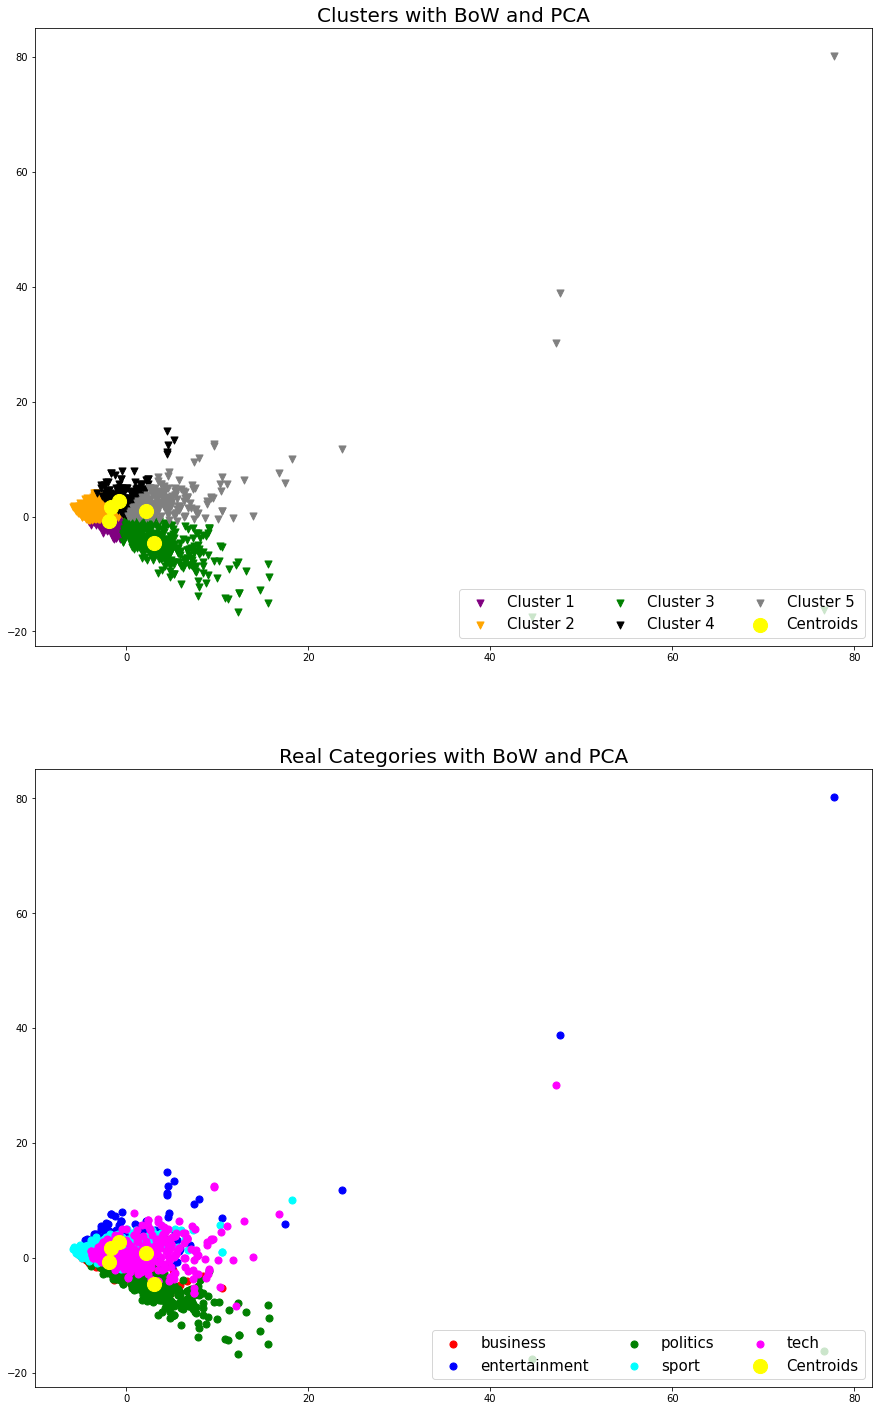

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with BoW and PCA',fontsize=20)
ax[1].set_title('Real Categories with BoW and PCA',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = pca_bowX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = pca_bowX_df.loc[pca_bowX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

Όπως παρατηρούμε, δεν εξάγεται κάποια πληροφορία.

### Τf-Idf with PCA

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(pca_tfidfX, assign_clusters=True)

centers = []
for category in categories:
  temp = pca_tfidfX_df[pca_tfidfX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

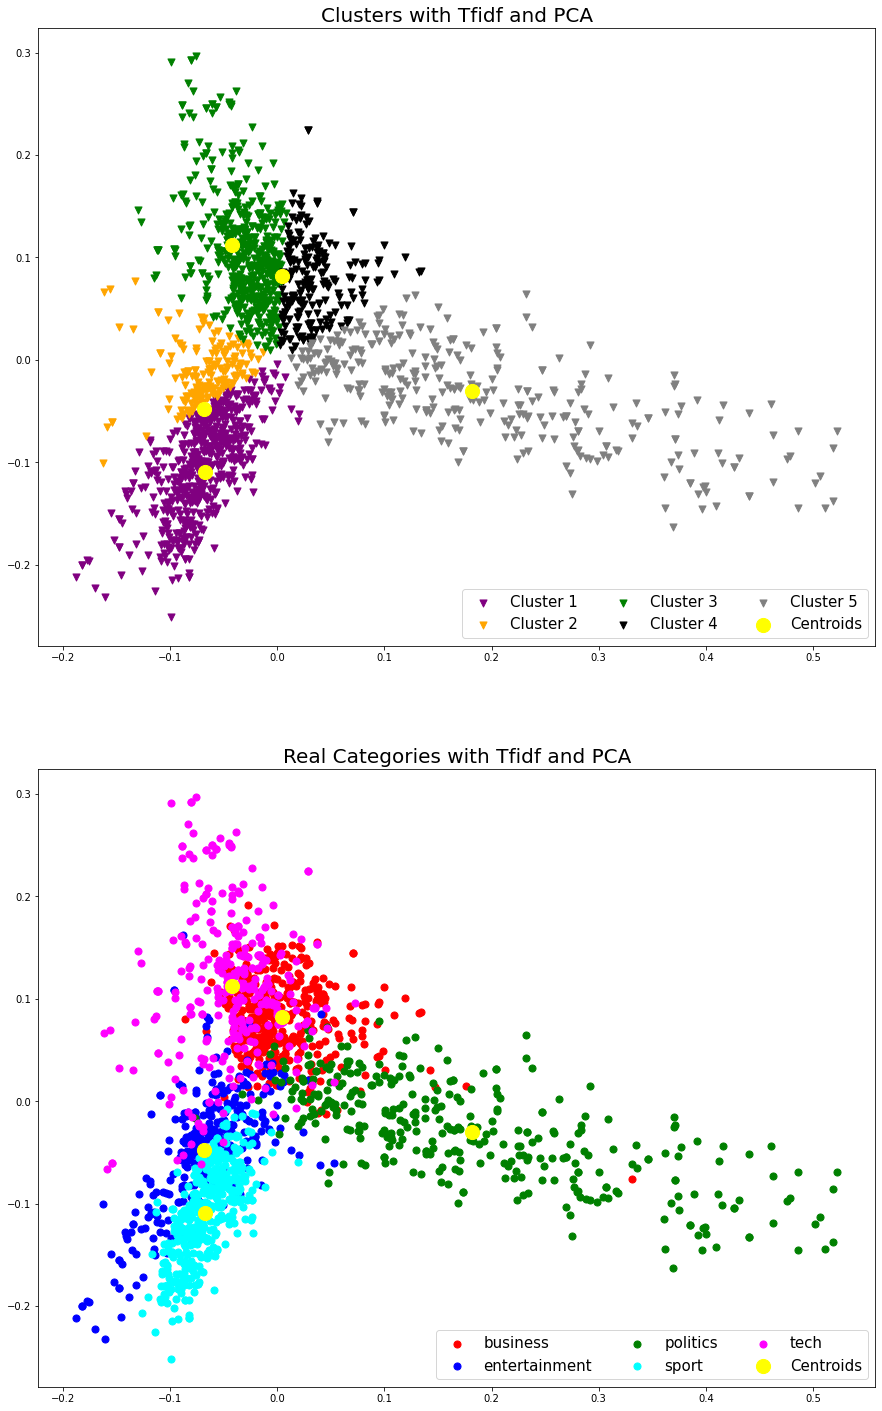

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Tfidf and PCA',fontsize=20)
ax[1].set_title('Real Categories with Tfidf and PCA',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = pca_tfidfX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = pca_tfidfX_df.loc[pca_tfidfX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

### Tf-Idf with SVD 

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(svd_tfidfX, assign_clusters=True)

centers = []
for category in categories:
  temp = svd_tfidfX_df[svd_tfidfX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']

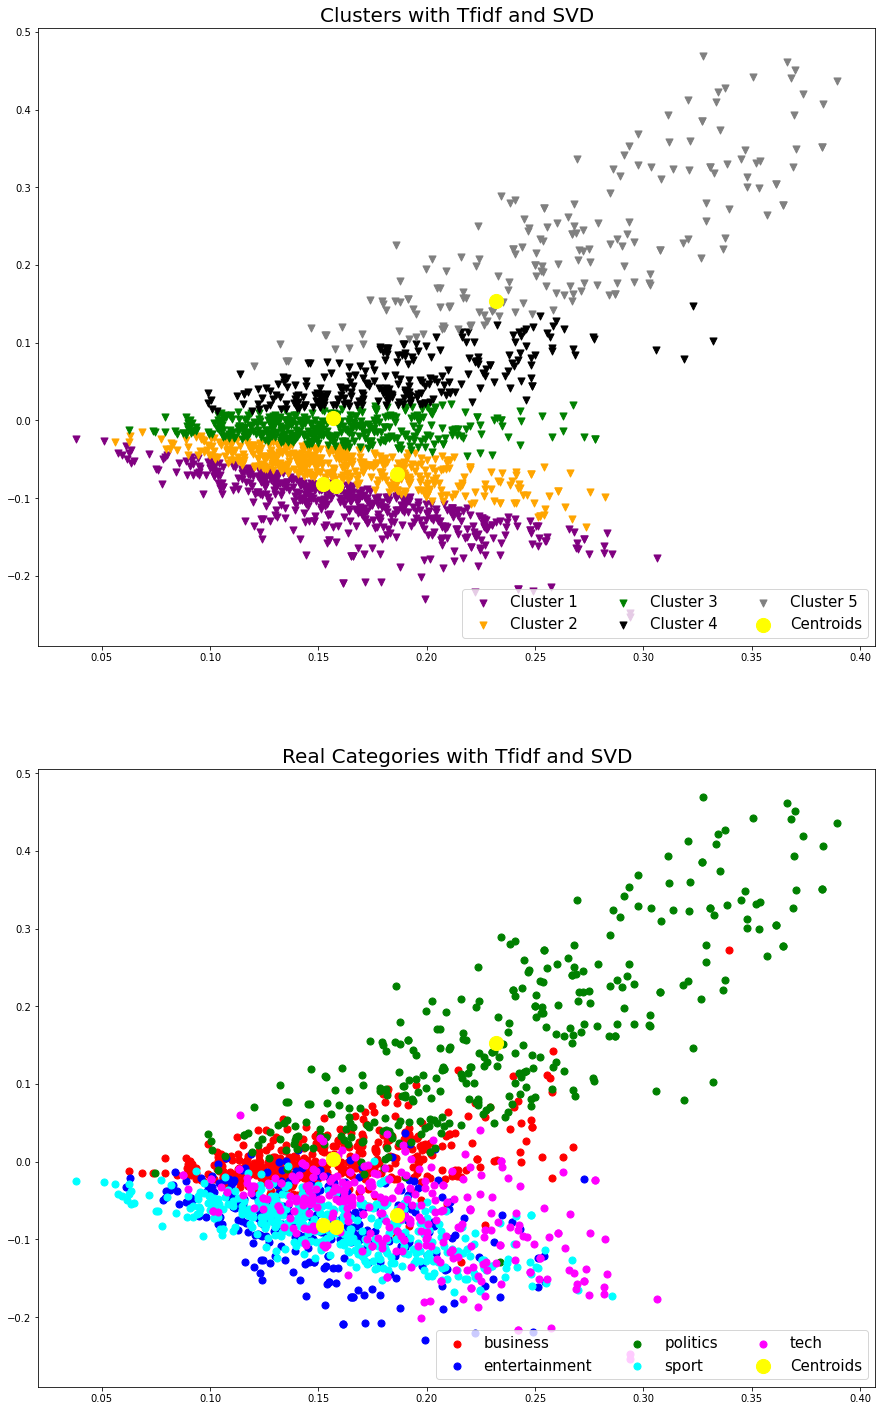

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Tfidf and SVD',fontsize=20)
ax[1].set_title('Real Categories with Tfidf and SVD',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = svd_tfidfX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = svd_tfidfX_df.loc[svd_tfidfX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

### Tf-Idf with ICA

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(ica_tfidfX, assign_clusters=True)

centers = []
for category in categories:
  temp = ica_tfidfX_df[ica_tfidfX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

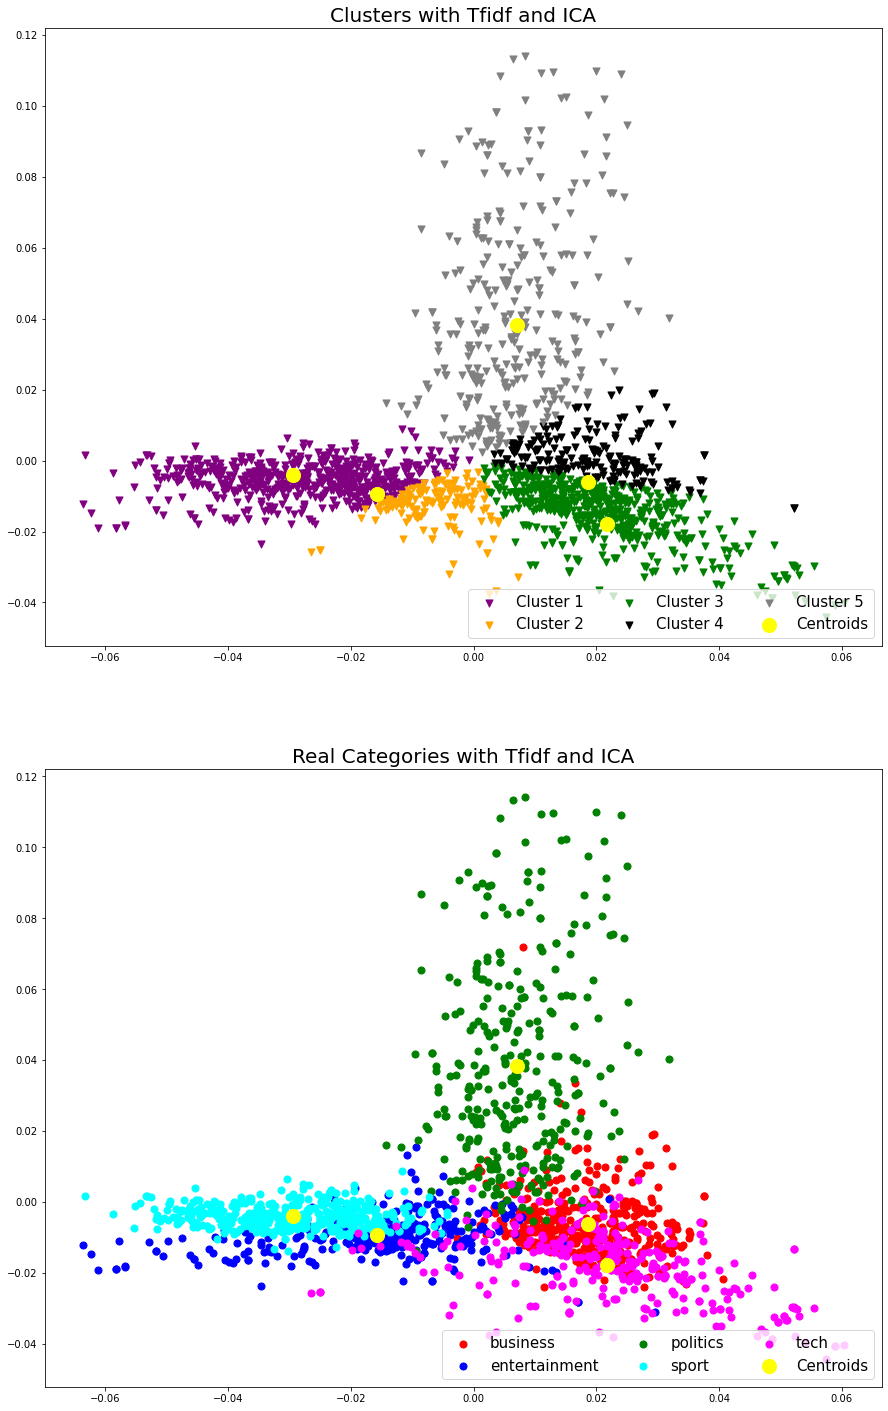

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Tfidf and ICA',fontsize=20)
ax[1].set_title('Real Categories with Tfidf and ICA',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = ica_tfidfX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = ica_tfidfX_df.loc[ica_tfidfX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

### Word2Vec with PCA

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(pca_w2vX, assign_clusters=True)

centers = []
for category in categories:
  temp = pca_w2vX_df[pca_w2vX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

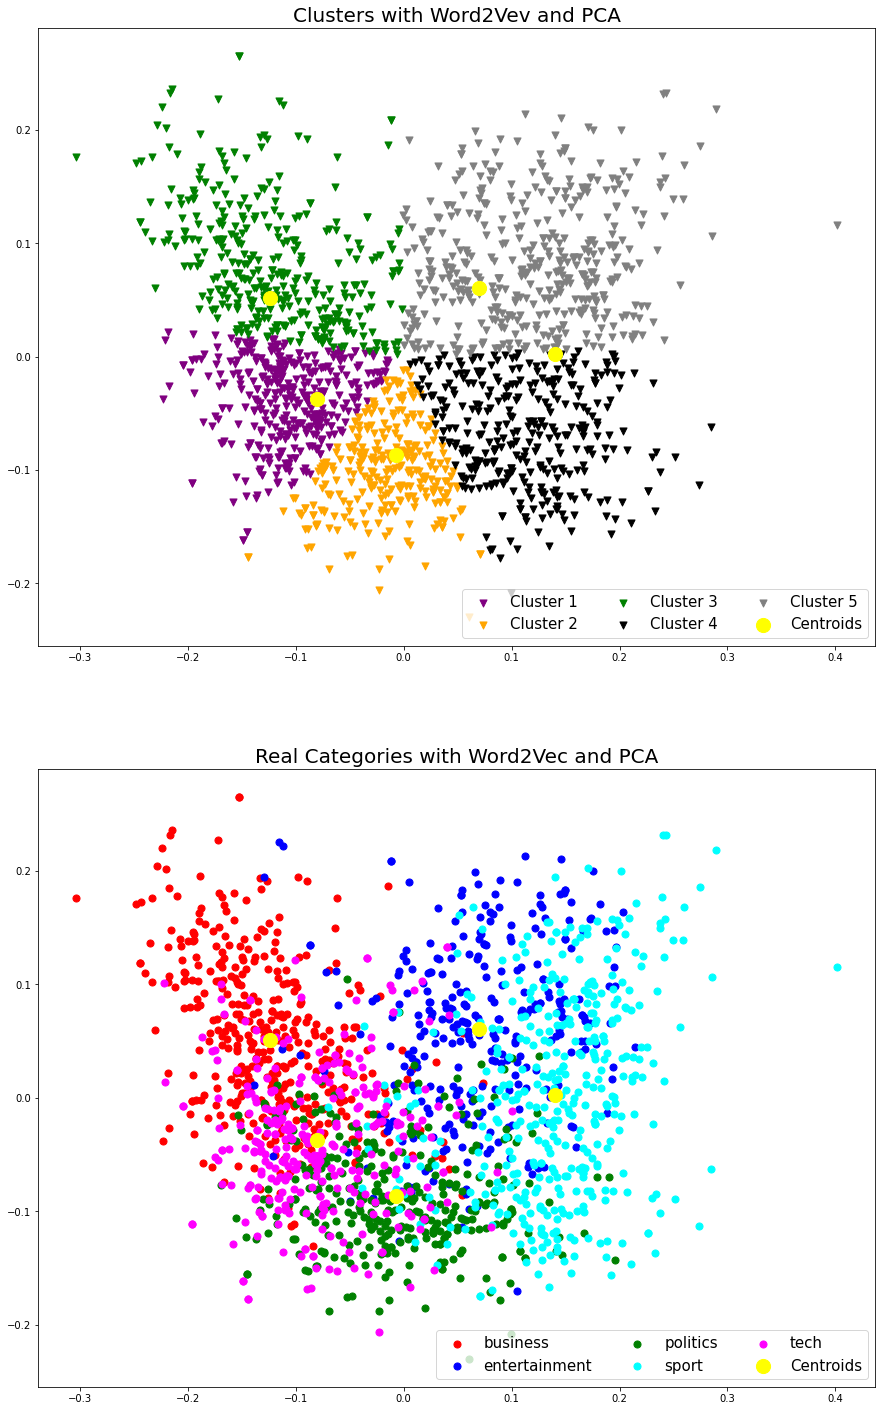

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Word2Vev and PCA',fontsize=20)
ax[1].set_title('Real Categories with Word2Vec and PCA',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = pca_w2vX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = pca_w2vX_df.loc[pca_w2vX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

### Word2Vec with SVD

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(svd_w2vX, assign_clusters=True)

centers = []
for category in categories:
  temp = svd_w2vX_df[svd_w2vX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

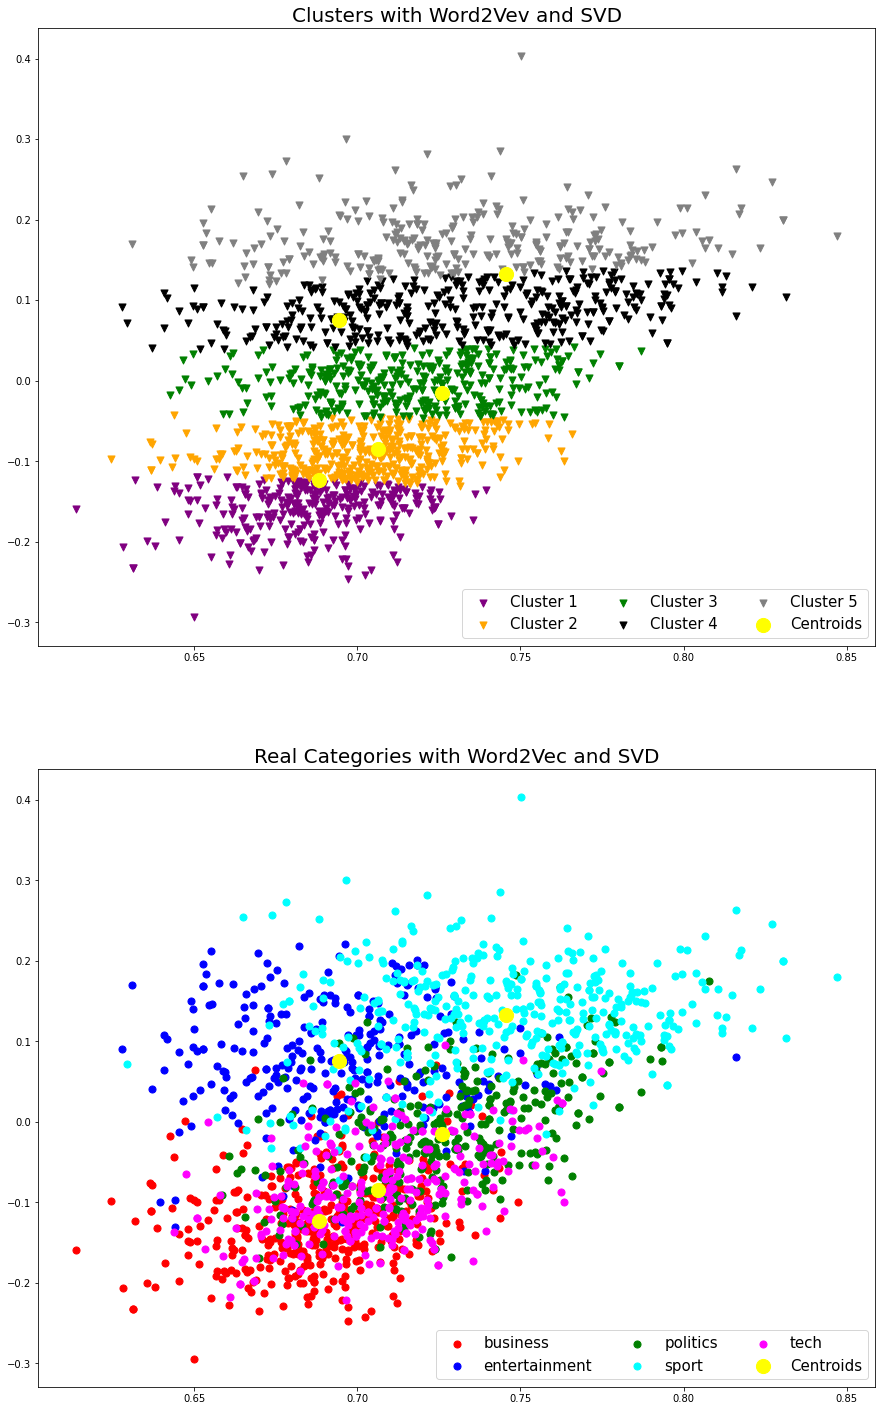

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Word2Vev and SVD',fontsize=20)
ax[1].set_title('Real Categories with Word2Vec and SVD',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = svd_w2vX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = svd_w2vX_df.loc[svd_w2vX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

### Word2Vec with ICA 

In [0]:
from nltk.cluster.kmeans import KMeansClusterer

kmeans = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
y_kmeans = kmeans.cluster(ica_w2vX, assign_clusters=True)

centers = []
for category in categories:
  temp = ica_w2vX_df[ica_w2vX_df['category']==category]
  centers.append([np.mean(temp['x']),np.mean(temp['y'])])
x_centers = [i[0] for i in centers]
y_centers = [i[1] for i in centers]

colors = ['red','blue','green','cyan','magenta']
categories = ['business','entertainment','politics','sport','tech']

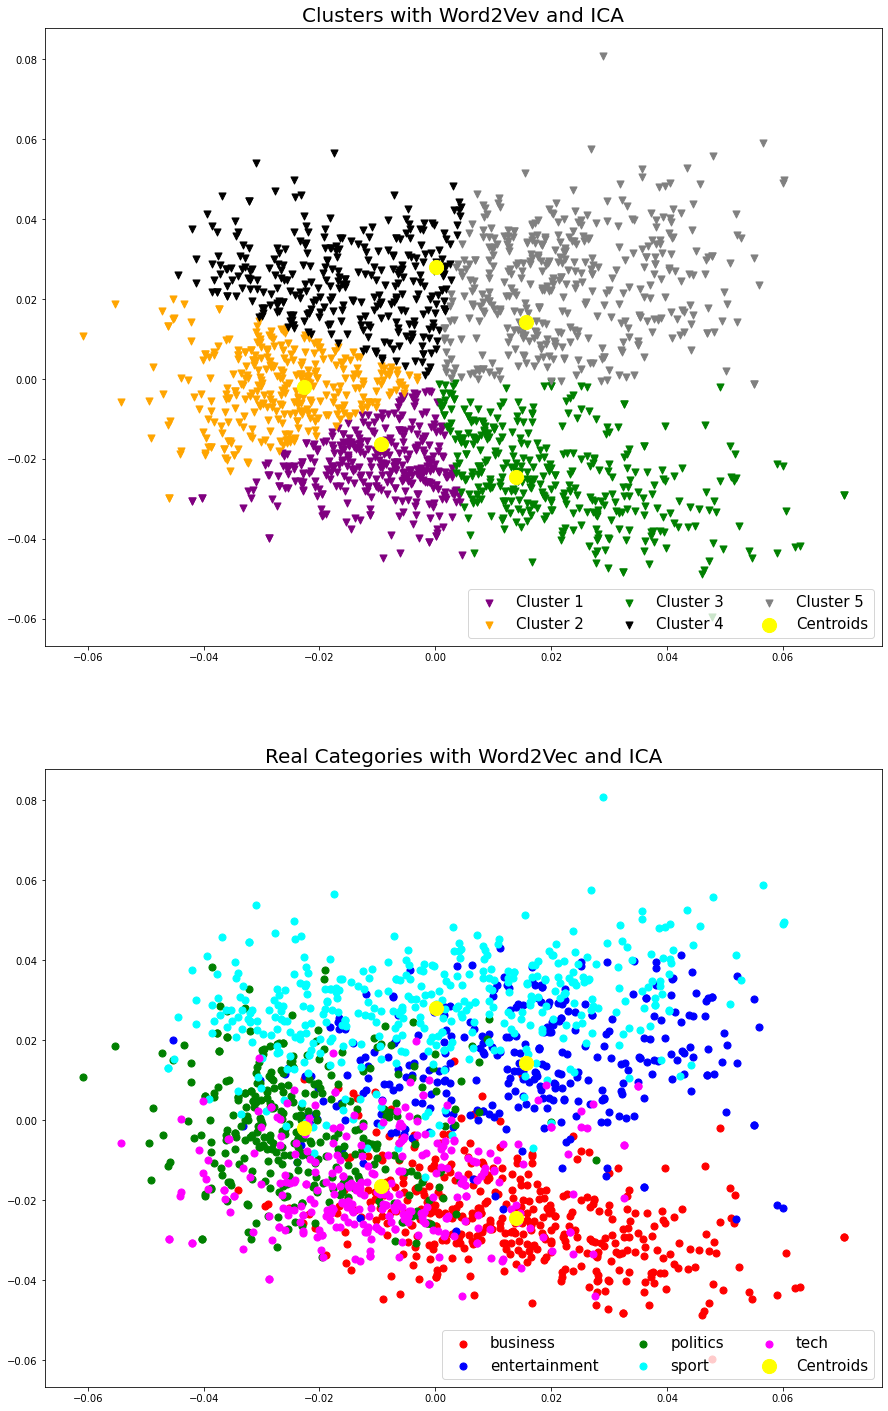

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,25))
ax[0].set_title('Clusters with Word2Vev and ICA',fontsize=20)
ax[1].set_title('Real Categories with Word2Vec and ICA',fontsize=20)

X0 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 0] 
X1 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 1] 
X2 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 2] 
X3 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 3] 
X4 = [i for i in range(len(y_kmeans)) if y_kmeans[i] == 4] 
X = ica_w2vX
ax[0].scatter(X[X0, 0], X[X0, 1], s=50, marker="v",c='purple', label ='Cluster 1')
ax[0].scatter(X[X1, 0], X[X1, 1], s=50, marker="v",c='orange', label ='Cluster 2')
ax[0].scatter(X[X2, 0], X[X2, 1], s=50, marker="v",c='green', label ='Cluster 3')
ax[0].scatter(X[X3, 0], X[X3, 1], s=50, marker="v",c='black', label ='Cluster 4')
ax[0].scatter(X[X4, 0], X[X4, 1], s=50, marker="v",c='grey', label ='Cluster 5')

i=0
for category in categories:
    temp_df = ica_w2vX_df.loc[ica_w2vX_df['category'] == category]
    x = temp_df['x'].tolist()
    y = temp_df['y'].tolist()
    ax[1].scatter(x,y,s=50,c = colors[i],label=category)
    i = i + 1    
        
ax[0].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[1].scatter(x_centers, y_centers, s=200, c='yellow', label = 'Centroids')
ax[0].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
ax[1].legend(
           loc='lower right',
           ncol=3,
           fontsize=15)
plt.show()

## e. Συμπεράσματα
Παρατηρήσεις:
- Σε σχέση με όλες τις αναπαραστάσεις, ο Κ-Μeans Clusterer **πλησίασε** τα πραγματικά categories **περισσότερο** στα γραφήματα **Tf-Idf with ICA** και **Tf-Idf with PCA**.
- Σε σχέση με τις αναπαραστάσεις Word2Vec, ο Κ-Μeans Clusterer **πλησίασε** τα πραγματικά categories **λιγότερο** στα γραφήματα **Word2Vec with PCA** και **Word2Vec with SVD**, με εξαίρεση το γράφημα με την μέθοδο **Word2Vec with ΙCA** που έκανε μία τίμια προσπάθεια.